In [ ]:
!pip install databento
!pip install --upgrade ipykernel

In [1]:
# Gym stuff
import tensorflow as tf
import databento as db

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from google.colab import drive
drive.mount('/content/test')

2024-02-11 12:42:08.079393: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 12:42:08.079524: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 12:42:08.087259: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-11 12:42:08.109946: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-11 12:42:12.831461: W tensorflow/compiler/tf2

Drive already mounted at /content/test; to attempt to forcibly remount, call drive.mount("/content/test", force_remount=True).


In [25]:
valid_stock = ["INTC", "AAPL", "GOOGL", "TSLA", "NVDA"]
stock = "none"
while(stock not in valid_stock):
  stock = input("Enter Stock: ")
  if (stock not in valid_stock):
    print("Try again these are our options: ", valid_stock)

Enter Stock: hitest
Try again these are our options:  ['INTC', 'AAPL', 'GOOGL', 'TSLA', 'NVDA']
Enter Stock: INTC


In [26]:
chunk_size = 100000
file_path = "test/MyDrive/" + stock + ".dbn"
df_iter = db.DBNStore.from_file(file_path).to_df(count = chunk_size)


In [27]:
df = next(df_iter)

In [28]:
df.reset_index(inplace = True)
df = df[["ts_event","open","high","low","close","volume"]]
df = df.rename(columns={'ts_event': 'Date'})
df.columns = [col.capitalize() for col in df.columns]

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-12-14 11:47:48+00:00,64.60,64.60,64.60,64.60,1
2018-12-14 11:47:49+00:00,64.59,64.59,64.59,64.59,200
2018-12-14 11:48:59+00:00,64.59,64.59,64.59,64.59,10
2018-12-14 12:00:00+00:00,64.59,64.59,64.54,64.54,150
2018-12-14 12:01:25+00:00,64.49,64.49,64.49,64.49,50


In [29]:
SENS_PARAM = 2.3
STDDEV_PARAM = 300
MEAN_PARAM = 300

df['Rolling_Mean'] = df['Close'].shift(-1).rolling(window=MEAN_PARAM).mean()
df['Rolling_Std_Dev'] = df['Close'].shift(-1).rolling(window=STDDEV_PARAM).std()
df = df.iloc[STDDEV_PARAM:]

def calculate_binary(row):
    if row['Rolling_Std_Dev'] != 0:  # Avoid division by zero
        if row['Close'] > row['Rolling_Mean'] + (row['Rolling_Std_Dev']  / SENS_PARAM):
            return 2
        elif row['Close'] < row['Rolling_Mean'] - (row["Rolling_Std_Dev"] / SENS_PARAM):
            return 0
    return 1

# Apply the function to create the "Binary" column
df['Classification'] = df.apply(calculate_binary, axis=1)
df.head(500)

,Open,High,Low,Close,Volume,Rolling_Mean,Rolling_Std_Dev,Classification
Date,,,,,,,,
2018-12-14 14:35:12+00:00,64.30,64.30,64.29,64.29,375,64.229500,0.272152,1
2018-12-14 14:35:13+00:00,64.30,64.30,64.30,64.30,200,64.228533,0.271382,1
2018-12-14 14:35:14+00:00,64.29,64.31,64.29,64.30,250,64.227633,0.270792,1
2018-12-14 14:35:15+00:00,64.29,64.29,64.27,64.27,339,64.226867,0.270372,1
2018-12-14 14:35:16+00:00,64.27,64.27,64.26,64.26,504,64.225867,0.269578,1
...,...,...,...,...,...,...,...,...
2018-12-14 14:52:49+00:00,64.95,64.95,64.94,64.95,1591,64.720133,0.230809,2
2018-12-14 14:52:51+00:00,64.95,64.95,64.95,64.95,100,64.721300,0.230983,2
2018-12-14 14:52:52+00:00,64.93,64.93,64.93,64.93,400,64.722467,0.231151,2


In [30]:
counts_2 = (df['Classification'] == 2).sum()
counts_1 = (df['Classification'] == 1).sum()
counts_0 = (df['Classification'] == 0).sum()

# Print the counts
print(f"Count of 2s: {counts_2}")
print(f"Count of 1s: {counts_1}")
print(f"Count of 0s: {counts_0}")

Count of 2s: 41680
Count of 1s: 17407
Count of 0s: 40613


In [31]:
df_scaled = df #lazyness
df_scaled_val = df_scaled[80000:]
df_scaled = df_scaled[0: 80000]
print(df_scaled_val.shape, df_scaled.shape)
train_percent = 0.75
embargo_pct = 0.1
features = len(df_scaled.columns)
data_samples = 90

test_percent = (1-train_percent+embargo_pct)

train_N = int((train_percent*len(df_scaled)))
test_N = int((test_percent*len(df_scaled)))

train_data = df_scaled.iloc[0:train_N]
test_data = df_scaled[-test_N:]

print(train_N)
print(test_N)
print(features)

(19700, 8) (80000, 8)
60000
28000
8


In [9]:
x_train=[]
y_train=[]

x_test = []
y_test = []

index_of_opt = features-1

for i in range(data_samples, train_N):
    x_train.append(train_data.iloc[i - data_samples:i].values)
    y_train.append(train_data.iloc[i][index_of_opt])

for i in range(data_samples, test_N):
    x_test.append(test_data.iloc[i - data_samples:i].values)
    y_test.append(test_data.iloc[i][index_of_opt])


x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(59910, 90, 8)
(59910,)
(27910, 90, 8)
(27910,)


In [11]:
learning_rate = 0.001
momentum = 0.1
epochs = 3

batch_size = 32

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='tanh', input_shape=(data_samples,features), return_sequences=False),
    tf.keras.layers.Dense(3)
])

In [12]:
optimizer1 = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.summary()


model.compile(optimizer=optimizer1, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
train_history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11800     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 11953 (46.69 KB)
Trainable params: 11953 (46.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3
1873/1873 [==============================] - 98s 51ms/step - loss: 0.5310 - accuracy: 0.7965 - val_loss: 0.2660 - val_accuracy: 0.9078
Epoch 2/3
1873/1873 [==============================] - 85s 45ms/step - loss: 0.2411 - accuracy: 0.9242 - val_loss: 0.2055 - val_accuracy: 0.9360
Epoch 3/3
1873/1873 [==============================] - 94s 50ms/step - loss: 0.2230 - accuracy: 0.9322 - val_loss: 0.2538 - va

In [13]:
def plot_training_history(history):
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    epochs = range(len(train_loss))

    # plot loss
    plt.clf()
    fig = plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(test_loss, label='test_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.title('Training and Testing Loss')
    plt.show()

<Figure size 640x480 with 0 Axes>

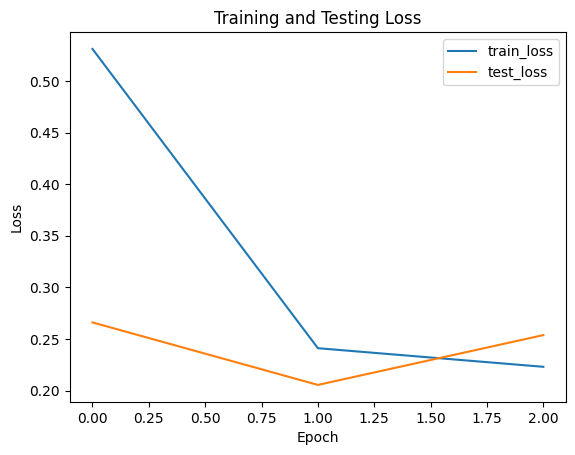

In [14]:
plot_training_history(train_history)

873/873 [==============================] - 12s 14ms/step


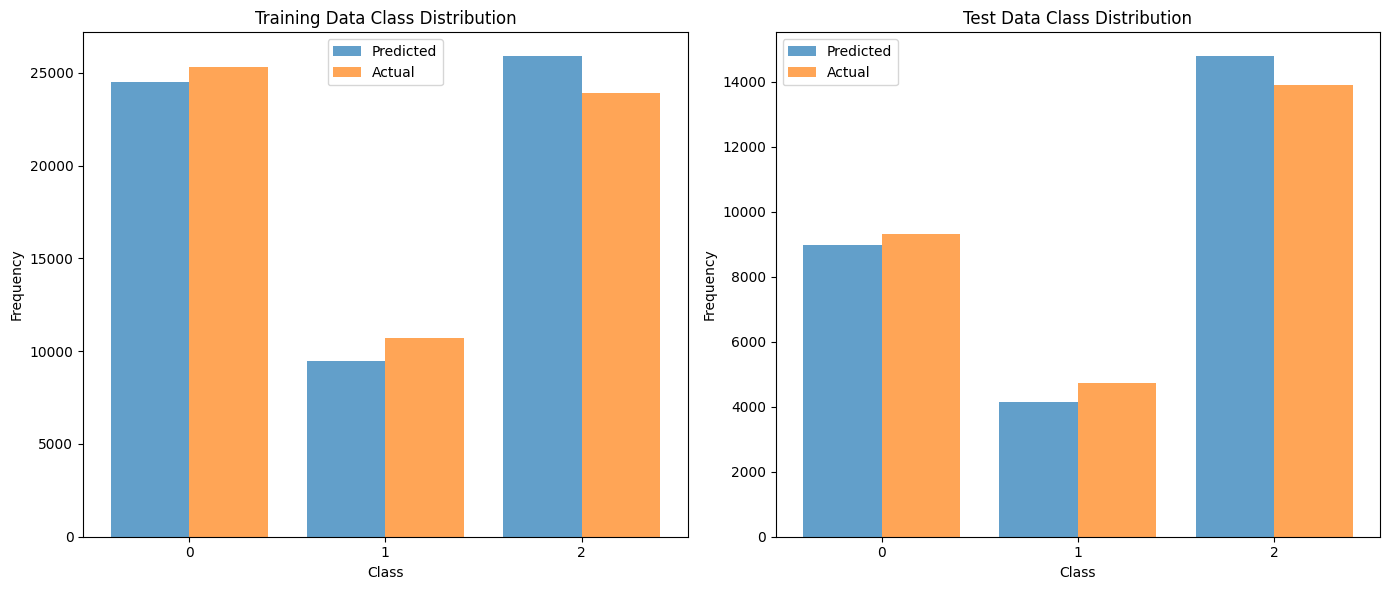

In [15]:
predicted_train = model.predict(x_train)
predicted_test = model.predict(x_test)

predicted_train_labels = np.argmax(predicted_train, axis=1)
predicted_test_labels = np.argmax(predicted_test, axis=1)

# Assuming your y_train and y_test are already in the correct format (0, 1, 2)
# If they're not (e.g., if they're -1, 0, 1), you'll need to adjust them accordingly
# y_train_adjusted = y_train + 1
# y_test_adjusted = y_test + 1

# Plotting histograms
# For training predictions
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist([predicted_train_labels, y_train], label=['Predicted', 'Actual'], bins=np.arange(-0.5, 3, 1), alpha=0.7)
plt.xticks([0, 1, 2])
plt.title('Training Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.legend()

# For test predictions
plt.subplot(1, 2, 2)
plt.hist([predicted_test_labels, y_test], label=['Predicted', 'Actual'], bins=np.arange(-0.5, 3, 1), alpha=0.7)
plt.xticks([0, 1, 2])
plt.title('Test Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
print(x_train[0].shape)
print((predicted_train[0]))
print(y_test[0])

(90, 8)
[-6.0321083 -0.7914014  3.7478528]
0.0


In [17]:
def plot_class_distributions(predicted_train_labels, y_train, predicted_test_labels, y_test, adjust_labels=False):
    # Plotting histograms
    plt.figure(figsize=(14, 6))

    # For training predictions
    plt.subplot(1, 2, 1)
    plt.hist([predicted_train_labels, y_train], label=['Predicted', 'Actual'], bins=np.arange(-0.5, max(y_train.max(), predicted_train_labels.max()) + 1.5, 1), alpha=0.7)
    plt.xticks(np.arange(0, max(y_train.max(), predicted_train_labels.max()) + 1))
    plt.title('Training Data Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.legend()

    # For test predictions
    plt.subplot(1, 2, 2)
    plt.hist([predicted_test_labels, y_test], label=['Predicted', 'Actual'], bins=np.arange(-0.5, max(y_test.max(), predicted_test_labels.max()) + 1.5, 1), alpha=0.7)
    plt.xticks(np.arange(0, max(y_test.max(), predicted_test_labels.max()) + 1))
    plt.title('Test Data Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

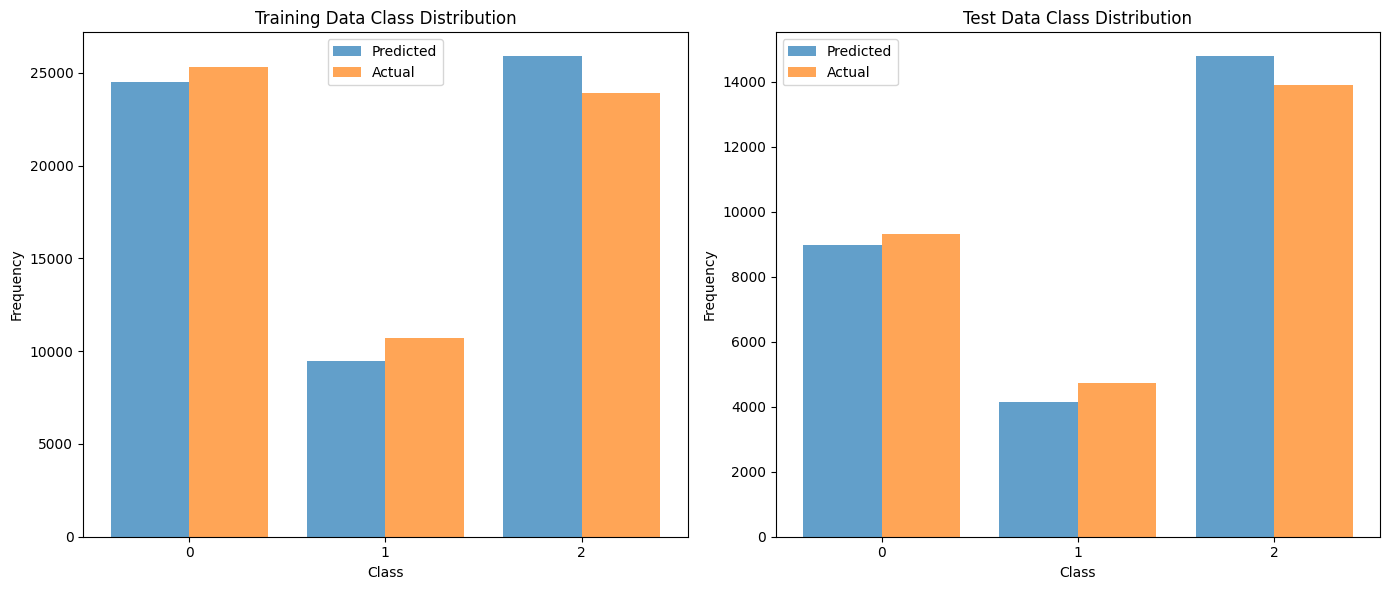

In [18]:
plot_class_distributions(predicted_train_labels, y_train, predicted_test_labels, y_test)  # Set adjust_labels as needed


In [19]:
#Backtesting

val_data = df_scaled_val
val_N = int((len(val_data)))

x_val = []
y_val = []

for i in range(data_samples, val_N):
    x_val.append(val_data.iloc[i - data_samples:i].values)
    y_val.append(val_data.iloc[i][index_of_opt])

# predicted = model.predict(val_data)
x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_val.shape)





(19610, 90, 8)


In [20]:
val_pred = model.predict(x_val)

613/613 [==============================] - 9s 14ms/step


In [21]:
predicted_val_labels = np.argmax(val_pred, axis=1)
print(predicted_val_labels.shape)
print(x_val.shape)
print(val_data['Close'][0])

(19610,)
(19610, 90, 8)
64.27


In [22]:
profit = 0
account = 1
counter = 0
loss_counter = 0
for curr_ts in range(len(x_val) - 2):
  profit += y_val[curr_ts] * (val_data['Close'][curr_ts + 1] - val_data['Close'][curr_ts])
  if y_val[curr_ts] == 0:
    account *= (val_data['Close'][curr_ts] / val_data['Close'][curr_ts + 1])
    if (val_data['Close'][curr_ts] / val_data['Close'][curr_ts + 1]) < 1:
      loss_counter += 1
  elif y_val[curr_ts] == 2:
    account *= (val_data['Close'][curr_ts + 1] / val_data['Close'][curr_ts])
    if (val_data['Close'][curr_ts + 1] / val_data['Close'][curr_ts]) < 1:
      loss_counter += 1
  counter += 1



In [23]:
print("$",profit)
print(account)
print((loss_counter / counter) * 100)

$ 13.784999999999968
1.2523965219191497
21.3484292125663


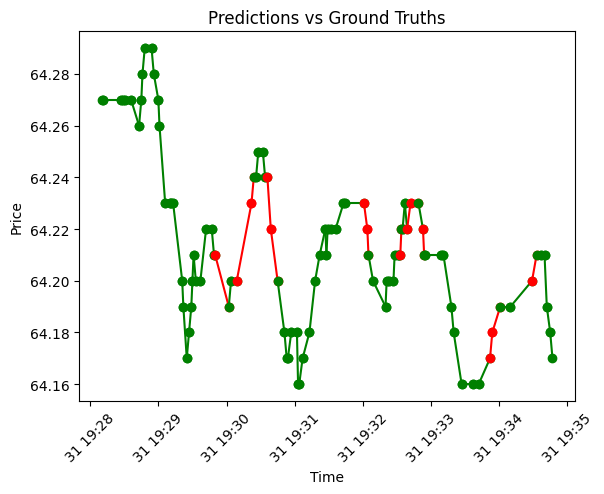

In [24]:
# y_val
# predicted_val_labels
ground_truth = y_val[:100]
predicted = predicted_val_labels[:100]

# print(val_data.iloc[0].name)

plt.figure()

for i in range(len(predicted) - 1):
    if ground_truth[i] == predicted[i]:
        plt.plot([val_data.iloc[i].name, val_data.iloc[i + 1].name], [val_data['Close'][i], val_data['Close'][i + 1]], 'go', linestyle='solid')  # Correct prediction, green
    else:
        plt.plot([val_data.iloc[i].name, val_data.iloc[i + 1].name], [val_data['Close'][i], val_data['Close'][i + 1]], 'ro', linestyle='solid')  # Incorrect prediction, red

# if predicted[99] == ground_truth[99]:
#     plt.plot(val_data.iloc[99].name, val_data['Close'][99], 'go')
# else:
#     plt.plot(val_data.iloc[99].name, val_data['Close'][99], 'ro')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Predictions vs Ground Truths')
# plt.legend()
plt.xticks(rotation=45)
# plt.grid(True)
plt.show()
